In [1]:
%matplotlib inline

import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

import numpy as np

from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tqdm import tqdm

width = 6
height = width/1.5
fsize = 16
font = {'size': fsize}    
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=fsize)
mpl.rc('ytick', labelsize=fsize)
mpl.rc('text', usetex=False)

np.random.seed(42)

In [2]:
Tc = 2 / np.log(1+np.sqrt(2))

In [3]:
# function to split the data
def split_data(X_data, y_data, T_data, Thi=4.7, Tlo=1.3, test_size=0,random_state=42):
    """
    Splits the data into train and test sets according to the settings.
    
    Either using sklearn train_test_split (test_size).  
    Or, alternatively, using T>Thi and T<Tlo data as training data and Tlo < T < Thi as predictions/test.
    """
    if test_size:
        print(f"Using sklearn to split data. Test size: {test_size*100:}%")
        X_train, X_test, y_train, y_test, T_train, T_test = \
          train_test_split(X_data, y_data, T_data, test_size=test_size, random_state=random_state)
    elif (Thi and Tlo):
        print(f"Using T>{Thi} and T<{Tlo} as training data.")
        train_set = np.logical_or(T_data>=Thi,T_data<=Tlo)
        test_set = np.logical_not(train_set)
        X_train = X_data[train_set]
        X_test = X_data[test_set]
        y_train = y_data[train_set]
        y_test = y_data[test_set]
        T_train = T_data[train_set]
        T_test = T_data[test_set]
    else:
        print("No rule to split data.")
        return None
        
    print(f"...Training samples: {X_train.shape[0]}")
    print(f"...Testing samples:  {X_test.shape[0]}")
    return(X_train, X_test, y_train, y_test, T_train, T_test)

In [4]:
### load data ###
fname = "ising_config_data_big.pkl"
d_data = pickle.load(open(fname,"rb"))

# make vector of input matrices, vector of temperatures
X_data = []
y_data = []
T_data = []

for T,configs in d_data.items():
    for config in configs:
        # flip spins to double dataset keeping E same
        # this is also needed so ML algorithm doesn't learn
        # to prefer one magnetization sign over another
        # also make truth labels (0 is low T phase, 1 is high T phase)
        # and also mirror lattice horizontally/vertically to get free data
        target = 0
        if T > Tc:
            target = 1
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):
            T_data.append(T)
            y_data.append(target)


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)

In [5]:
x_train, x_test, y_train, y_test, T_train, T_test = split_data(X_data, y_data, T_data,test_size=0.3)

Using sklearn to split data. Test size: 30.0%
...Training samples: 4200
...Testing samples:  1800


# Project II: Machine Learning the Ising Phase Transition
## Learning from data [TIF285], Chalmers, Fall 2019

#### Christian Forssén and Shahnawaz Ahmed, Chalmers
Last revised: 16-Oct-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional and only gives extra points. See examination rules on the course web page.
- Hand-in your written report via Canvas.

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure form or in a table. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

## Project background and main tasks

See the `TIF285-project2.ipynb` notebook for the project background and the description of the main tasks. This notebook just contains a description of the extra tasks.

## Task 4: Understanding the neural network (extra)

You have implemented three different strategies based on Neural Networks to identify phase transitions from raw data. But what do the networks learn and what can they tell us about phase transitions? Do the networks understand the concept of magnetization or critical temperature? Or they are just memorizing the data and an input-output relationship?

* In this task you will try to reproduce the results from the toy-model in the Supplementary section of the paper Carrasquilla, Juan, and Roger G. Melko. ``Machine learning phases of matter.'' [Nature Physics (2017) 13, 431–434](https://www.nature.com/articles/nphys4035).

* First, read section 1 in the [supplemenart section](https://media.nature.com/original/nature-assets/nphys/journal/v13/n5/extref/nphys4035-s1.pdf) to understand the toy model and how the authors have parameterized the weights such that the result of the first hidden layer network is a function of the magnetization, i.e, $Wx + b = \frac{1}{1+\epsilon}\{m(x) - \epsilon, -m(x) - \epsilon, m(x) + \epsilon\}$. The design is such that the first two perceptrons activate when the input states are mostly polarized, while the third one activate if the states are polarized up or unpolarized.

* Your task is to show that in a single-hidden layered network implemented to classify phases, the intermediate result $Wx + b$ follows the toy model proposed in the paper, i.e., the intermediate output as a function of magnetization give three different straight lines with their slopes being $\pm \alpha$ where $\alpha$ is some arbitrary number.

### Sub-tasks

* Train a neural network with three neurons in the hidden layer (using a sigmoid activation function) and plot the intermediate output as a function of the magnetization. 

  [*Hint*: in order to get a plot similar to the paper, you might need to make your input symmetric by encoding the spins as +1 and -1]


* Fit straight lines to your plots to show that your trained network approximately fits the proposed toy model in the paper, i.e., that you get straight lines with approximately the following behaviour $Wx + b = \frac{1}{1+\epsilon}\{m(x) - \epsilon, -m(x) - \epsilon, m(x) + \epsilon\}$
  

* Now train a network with **10 neurons** in the hidden layer and show that there is a redundancy in the number of neurons by plotting the $Wx + b$ for all of them to show that most neurons behave in one of four different ways.


* *Bonus*: Comment on why the intermediate outputs from a **10 neuron network** gets grouped into four classes instead of the three as per the toy-model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________
train accuracy: 0.965
test accuracy: 0.9488889


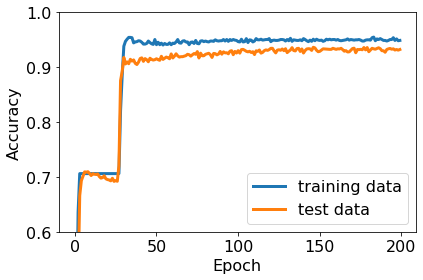

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
train accuracy: 0.9576191
test accuracy: 0.9444444


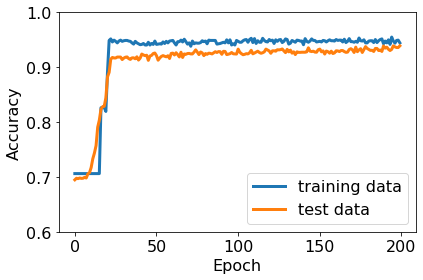

In [6]:
### define & run nn ###
nn_3neurons = Sequential([
    Flatten(input_shape=(10, 10)),
    Dense(3, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(1e-2)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])
nn_10neurons = Sequential([
    Flatten(input_shape=(10, 10)),
    Dense(10, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(1e-2)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

for nn in [nn_3neurons, nn_10neurons]:
    nn.summary()
    nn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    hist = nn.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=200, verbose=0)

    ### evaluate nn ###
    train_loss, train_acc = nn.evaluate(x_train,  y_train, verbose=0)
    test_loss, test_acc = nn.evaluate(x_test, y_test, verbose=0)
    print('train accuracy:', train_acc)
    print('test accuracy:', test_acc)
    
    ### plot learning rates ###
    fig, ax = plt.subplots()
    ax.plot(hist.history['val_accuracy'], label=r'training data', linewidth=3.0)
    ax.plot(hist.history['accuracy'], label=r'test data', linewidth=3.0)
    ax.set_xlabel(r'Epoch', fontsize=fsize)
    ax.set_ylabel(r'Accuracy', fontsize=fsize)
    ax.set_ylim(bottom=0.6, top=1.)

    plt.legend(fontsize=fsize)
    plt.tight_layout()
    intermediate_output_dim = nn.weights[0].numpy().shape[1]
    plt.savefig('bonus_task_' + str(intermediate_output_dim) + '_neurons_performance.pdf')
    plt.show()

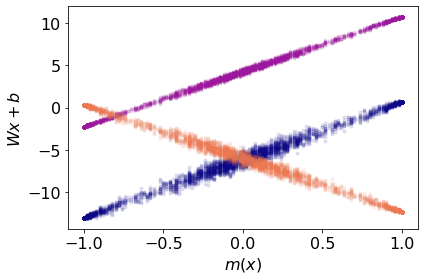

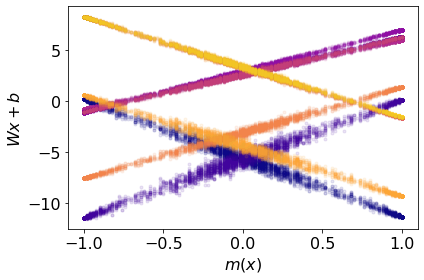

In [7]:
### define magnetization ###
def m(x):
    return np.mean(x)

### define y = ax + b ###
def straight_line(x, a, b):
    return a * x + b # b is defined as th p=0.5 point, so we just extract this

for nn in [nn_3neurons, nn_10neurons]:
    ### calculate intermediate output ###
    weights = nn.weights[0].numpy()
    bias = nn.weights[1].numpy()

    intermediate_output_dim = weights.shape[1]
    intermediate_output = np.empty((len(x_train), intermediate_output_dim)) # initiate
    for i, x in enumerate(x_train):
        intermediate_output[i,:] = weights.T @ x.flatten() + bias

    ### plot intermediate output to magnitization ###
    m_list = np.array([m(x) for x in x_train])
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$m(x)$', fontsize=fsize)
    ax.set_ylabel(r'$W x + b$', fontsize=fsize)
    
    ### loop over output vector ###
    plasma = plt.cm.plasma(np.linspace(0, 1, intermediate_output_dim + 1)) # color for plots
    for i in range(intermediate_output_dim):
        ax.plot(m_list, intermediate_output[:,i], '.', alpha=0.1,  color=plasma[i])
        
        ### fit straight line to intermediate output ###
        y_pred = nn.predict(x_test)
        (a, b), pcov = curve_fit(straight_line, m_list, intermediate_output[:,i], p0=(1., -2.))
        #ax.plot(m_list, a * m_list + b, '-', color=plasma[i])
 
    #plt.legend(fontsize=fsize)
    plt.tight_layout()
    plt.savefig('bonus_task_' + str(intermediate_output_dim) + '_neurons_line_fit.pdf')
    plt.show()

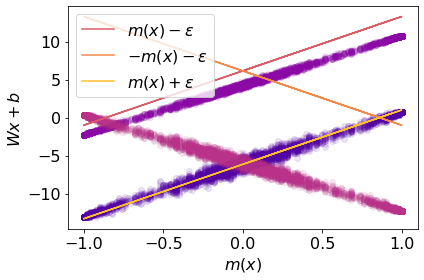

In [8]:
### FIT 1/(1+𝜖){𝑚(𝑥)−𝜖,−𝑚(𝑥)−𝜖,𝑚(𝑥)+𝜖} TO DATA ###

### define function to fit ###
def epsilon_thingy(X, eps):
    M = np.array([m(x) for x in X])
    return 1/(1 + eps) * (np.array([M, -M, M]).T + np.array([-eps, -eps, eps]))

### calculate intermediate output ###
weights = nn_3neurons.weights[0].numpy()
bias = nn_3neurons.weights[1].numpy()

intermediate_output_dim = weights.shape[1]
intermediate_output = np.empty((len(x_train), intermediate_output_dim)) # initiate
for i, x in enumerate(x_train):
    intermediate_output[i,:] = weights.T @ x.flatten() + bias

colors = plasma = plt.cm.plasma(np.linspace(0, 1, 8)) # color for plot
labels = [r'$m(x) - \epsilon$', r'$-m(x) - \epsilon$', r'$m(x) + \epsilon$']
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(np.array([m(x) for x in x_train]), intermediate_output[:,i], 'o', alpha=0.1, color=plasma[i+1])
    ax.plot(np.array([m(x) for x in x_train]), epsilon_thingy(x_train, -0.86)[:,i], color=plasma[i+4], zorder=4, label=labels[i])

ax.set_xlabel(r'$m(x)$', fontsize=fsize)
ax.set_ylabel(r'$W x + b$', fontsize=fsize)

plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig('epsilon_model_fit.pdf')
plt.show()

## Task 5: A simple Bayesian neural network (extra)

Create a bayesian binary classifier that can take $(E,|m|)$ as input data and predict a binary label (0=below $T_c$, 1=above $T_c$). 
* Use only high- and low-tempterature data for training (so that predictions for intermediate temperature data should be more difficult). Use normalized data as in Task 1.
* The weights (and bias) of the single neuron binary classifier will be described by pdf:s that we will sample from using MCMC.
* Use a Gaussian prior on the two weights and the bias (with ``weight decay'' $\sigma = 1.0)$.
* Construct the (log) likelihood as in logistic regression (i.e. as used in Task 1). 
* Use, e.g., `emcee`, for the MCMC sampling.
* The prediction for a given input should be characterized by a pdf; i.e. the predicted probability for the state belonging to class 1 (above $T_c$) will itself be described by a pdf.

#### Sub-tasks
(a) Plot the pdf:s for the weights and the bias of your Bayesian binary classifier.

(b) Study in particular the **prediction** of your Bayesian binary classifier for inputs $(E,|m|)$ that corresponds to:
1. a low-temperature configuration.
1. a high-temperature configuration.
1. a temperature very close to the critical one.

In [9]:
points = np.loadtxt('points.txt')
points_full = np.loadtxt('points_full.txt')

high_T = points_full[:,0]>Tc
low_T = points_full[:,0]<Tc

E_M_high = points_full[high_T][:,1:]
E_M_low = points_full[low_T][:,1:]

In [10]:
def sigmoid(a):
    return 1/(1. + np.exp(-a))

def feed_forward(w,X):
    """Returns the "probability" of being in the unordered phase. Takes the wight w of the neuron\
     and the indata X to the neuron."""
    z = w[0] + X@w[1:3]
    y = sigmoid(z)
    return y

def make_predict(w,X):
    prob = feed_forward(w,X)
    return np.round(prob)

def log_prior2(w):
    """ Returns a gaussisk log prior with standard deviation 1. Takes the weights as input."""
    sigma = 1
    return -w.shape[0]/2*np.log(2*np.pi*sigma**2) - 1/2*(w.dot(w))/sigma**2

def log_likelihood2(w,X_train,targets):
    """Returns the log of the likelihood. The log likelihood is given by the sum of cross entropy.\
     The input should be w the weight X_train the indata energy e in first colomn and magnetization in the second\
      and targets 0 or 1."""
    prob = feed_forward(w,X_train)
    like = np.sum(targets*np.log(prob) + (1-targets)*np.log(1-prob))
    return like

def log_posterior2(w,X_train,targets):
    """ Returns the log posterior (sum of log prior and log likelihood). Takes weights, indata an targets as input."""
    return log_likelihood2(w,X_train,targets) + log_prior2(w)

Using T>3.5 and T<1.5 as training data.
...Training samples: 400
...Testing samples:  800


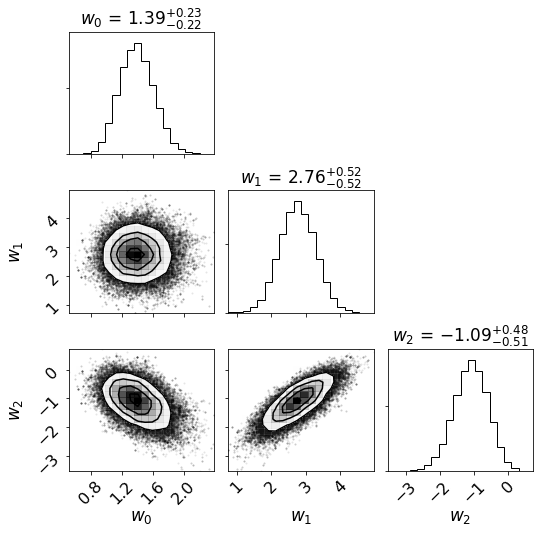

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from emcee import EnsembleSampler as ensembleSampler
import corner
import seaborn as sns

fsize = 17
dim = 3
nbr_walkers = 10
nbr_warmup = 100
nbr_samples = 10000

initial_positions = np.random.rand(nbr_walkers,dim)

inputs = np.append(E_M_low, E_M_high, axis=0)
labels = np.append(np.zeros_like(E_M_low[:,0]), np.ones_like(E_M_high[:,0]), axis=0)

X_train, X_test, Y_train, Y_test, T_train, T_test = split_data(inputs,labels,points_full[:,0],Thi =3.5 , Tlo = 1.5)
mean = np.mean(inputs, axis=0)
std = np.sqrt(np.var(inputs, axis=0))
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

sampler = ensembleSampler(nbr_walkers, dim, log_posterior2, args = (X_train_normalized,Y_train))
pos, tr, pr = sampler.run_mcmc(initial_positions, nbr_warmup)
sampler.reset()
sampler.run_mcmc(pos, nbr_samples);
samples = sampler.flatchain

corner.corner(samples, labels=[r'$w_0$', r'$w_1$', r'$w_2$'], label_kwargs={'fontsize': 17},
                            show_titles=True, title_kwargs={'fontsize': 17})

w = np.mean(samples,axis = 0)

plt.tight_layout() 
plt.savefig('bnn_corner.pdf')

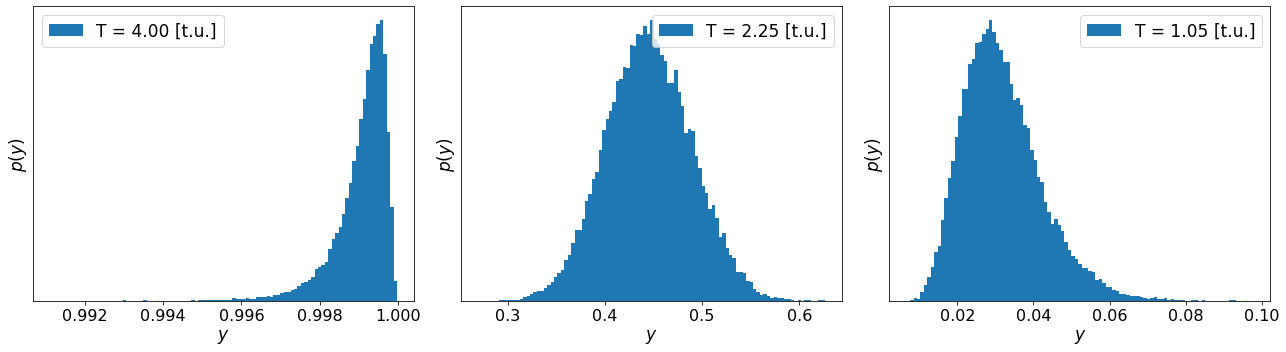

In [12]:
mean_full = points_full[:,1:3].mean(axis = 0)
std_full = np.sqrt(points_full[:,1:3].var(axis = 0))

indecies = np.array([1,706,1191]) # take this to ne 1 high 1 low 1 medum temp

y = np.zeros((len(indecies),samples.shape[0]))
fig,ax = plt.subplots(1,3,figsize=(18,5))
for j,index in enumerate(indecies):
    X = (points_full[index,1:3] - mean_full) / std_full
    
    y[j,:] = feed_forward(samples.T,X)
    
    ax[j].hist(y[j,:].T,bins = 101,density = True,label = f"T = {points_full[index,0]:.2f} [t.u.]")
    ax[j].set_ylabel(r"$p(y)$",fontsize = fsize)
    ax[j].set_xlabel(r"$y$",fontsize = fsize)
    ax[j].set_yticks([])
    ax[j].legend(fontsize = fsize)
        
plt.tight_layout() 
plt.savefig('bnn_three_case.pdf')

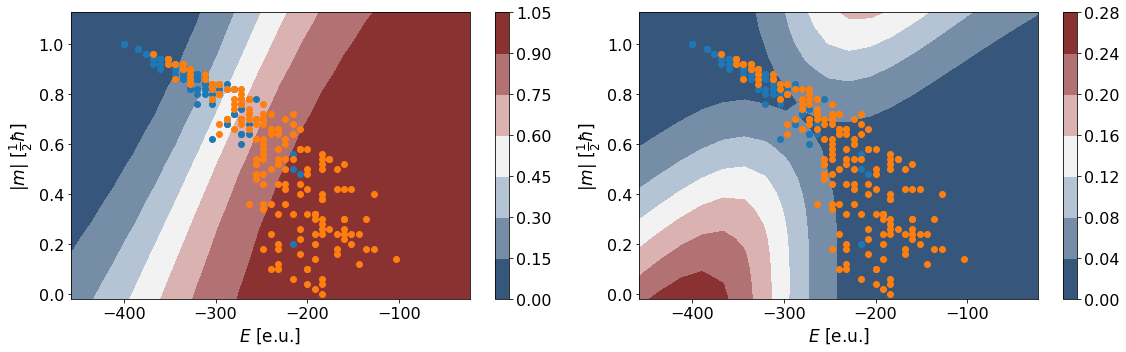

In [13]:
E_grid = E = np.linspace(-1.8, 2.,20)
m_grid = np.linspace(-1.6,1.5,20)

predict = np.zeros((len(E_grid), len(m_grid), samples.shape[0]))
for i,e in enumerate(E_grid):
    for j,m in enumerate(m_grid):
        X_data = np.array([e,m])
        predict[i,j,:] = feed_forward(samples.T,X_data)

fig,ax = plt.subplots(1,2,figsize = (16,5))
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
contourf0 = ax[0].contourf(mean[0] + std[0]*E_grid, mean[1] + std[1]*m_grid, predict.mean(axis = 2).T, cmap=cmap)
contourf1 = ax[1].contourf(mean[0] + std[0]*E_grid, mean[1] + std[1]*m_grid, np.sqrt(predict.var(axis = 2)).T,cmap = cmap)

pred = make_predict(w,X_train_normalized)
ax[0].scatter(mean[0] + std[0]*X_train_normalized[Y_train==0, 0], mean[1] + std[1]*X_train_normalized[Y_train==0, 1])
ax[0].scatter(mean[0] + std[0]*X_train_normalized[Y_train==1, 0], mean[1] + std[1]*X_train_normalized[Y_train==1, 1])
ax[1].scatter(mean[0] + std[0]*X_train_normalized[Y_train==0, 0], mean[1] + std[1]*X_train_normalized[Y_train==0, 1])
ax[1].scatter(mean[0] + std[0]*X_train_normalized[Y_train==1, 0], mean[1] + std[1]*X_train_normalized[Y_train==1, 1])

cbar0 = plt.colorbar(contourf0, ax=ax[0])
cbar1 = plt.colorbar(contourf1, ax=ax[1])

ax[0].set_xlabel(r"$E$ [e.u.]", fontsize=fsize)
ax[0].set_ylabel(r"$|m|$ $[\frac{1}{2}\hbar]$", fontsize=fsize)
ax[1].set_xlabel(r"$E$ [e.u.]", fontsize=fsize)
ax[1].set_ylabel(r"$|m|$ $[\frac{1}{2}\hbar]$", fontsize=fsize)

plt.tight_layout() 
plt.savefig('bnn_mean_std.pdf')